Librairies importées.
Dataset chargé avec 17515 lignes.

Répartition de la cible AVANT SMOTE :
est_absent
0    14002
1       10
Name: count, dtype: int64

--- Application de SMOTE pour rééquilibrer le set d'entraînement ---

Répartition de la cible APRÈS SMOTE :
est_absent
0    14002
1    14002
Name: count, dtype: int64

--- Entraînement du modèle LightGBM sur les données rééquilibrées ---
[LightGBM] [Info] Number of positive: 14002, number of negative: 14002
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 115
[LightGBM] [Info] Number of data points in the train set: 28004, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Entraînement terminé !

--- Évaluation du modèle sur le set de test D'ORIGINE ---
Meilleur seuil trouvé :

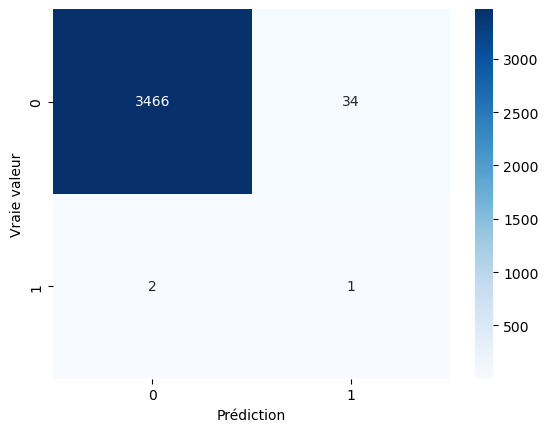


Modèle (amélioré avec SMOTE) sauvegardé dans : ../models/absence_predictor_model.pkl


In [2]:
# ==============================================================================
# NOTEBOOK 2 FINAL (Version 2) : ENTRAÎNEMENT AVEC SMOTE
# ==============================================================================
import pandas as pd
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# Importation de SMOTE
from imblearn.over_sampling import SMOTE

print("Librairies importées.")

# --- 1. CHARGEMENT (inchangé) ---
df = pd.read_csv('data/dataset_absences.csv')
print(f"Dataset chargé avec {len(df)} lignes.")

# --- 2. PRÉPARATION DES DONNÉES (inchangé) ---
TARGET_COLUMN = 'est_absent'
FEATURES_COLUMNS = [col for col in df.columns if col not in [TARGET_COLUMN, 'employe_id', 'date']]
X = df[FEATURES_COLUMNS]
y = df[TARGET_COLUMN]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\nRépartition de la cible AVANT SMOTE :")
print(y_train.value_counts())

# --- 3. RÉ-ÉCHANTILLONNAGE AVEC SMOTE (NOUVELLE ÉTAPE) ---
print("\n--- Application de SMOTE pour rééquilibrer le set d'entraînement ---")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nRépartition de la cible APRÈS SMOTE :")
print(y_train_resampled.value_counts())

# --- 4. ENTRAÎNEMENT DU MODÈLE (MODIFIÉ) ---
print("\n--- Entraînement du modèle LightGBM sur les données rééquilibrées ---")
# On n'a PLUS besoin de scale_pos_weight car SMOTE a fait le travail
model = LGBMClassifier(
    objective='binary',
    n_estimators=100,
    random_state=42
)
# On entraîne sur les données "resampled" !
model.fit(X_train_resampled, y_train_resampled)
print("\nEntraînement terminé !")

# --- 5. ÉVALUATION DU MODÈLE (inchangé) ---
print("\n--- Évaluation du modèle sur le set de test D'ORIGINE ---")
y_pred_proba = model.predict_proba(X_test)[:, 1]

# On va trouver un meilleur seuil que 0.5
# Pour cela, on teste plusieurs seuils et on regarde le F1-score
best_f1 = 0
best_threshold = 0.5
for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
    y_pred_temp = (y_pred_proba > threshold).astype(int)
    report = classification_report(y_test, y_pred_temp, output_dict=True)
    f1 = report['1']['f1-score']
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold
print(f"Meilleur seuil trouvé : {best_threshold} (avec un F1-score de {best_f1:.4f} pour la classe 'Absent')")

# On utilise ce meilleur seuil pour nos prédictions finales
y_pred = (y_pred_proba > best_threshold).astype(int)

print("\n1. Rapport de Classification (avec meilleur seuil) :\n")
print(classification_report(y_test, y_pred))

auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"2. Score AUC-ROC : {auc_score:.4f} (devrait être > 0.8 maintenant)")

print("\n3. Matrice de Confusion :")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédiction')
plt.ylabel('Vraie valeur')
plt.show()

# --- 6. SAUVEGARDE (inchangé) ---
MODEL_PATH = '../models/absence_predictor_model.pkl'
joblib.dump(model, MODEL_PATH)
print(f"\nModèle (amélioré avec SMOTE) sauvegardé dans : {MODEL_PATH}")